# Credit Fraud with Neural Network


## Import libraries

In [1]:
# Check keras and tensorflow versions
import tensorflow as tf
import keras 

print("Keras version: ", keras.__version__)
print("Tensorflow version: ", tf.__version__)

Keras version:  2.4.3
Tensorflow version:  2.3.0


In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

from scipy import stats
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from imblearn.over_sampling import SMOTE

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [3]:
clf = Sequential([
    Dense(units=16, kernel_initializer='uniform', input_dim=30, activation='relu'),
    Dense(units=18, kernel_initializer='uniform', activation='relu'),
    Dropout(0.25),
    Dense(20, kernel_initializer='uniform', activation='relu'),
    Dense(24, kernel_initializer='uniform', activation='relu'),
    Dense(1, kernel_initializer='uniform', activation='sigmoid')
])

In [4]:
clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                496       
_________________________________________________________________
dense_1 (Dense)              (None, 18)                306       
_________________________________________________________________
dropout (Dropout)            (None, 18)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                380       
_________________________________________________________________
dense_3 (Dense)              (None, 24)                504       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total params: 1,711
Trainable params: 1,711
Non-trainable params: 0
______________________________________________________

In [5]:
DATAFILE = 'creditcard.csv'
df = pd.read_csv(DATAFILE)

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

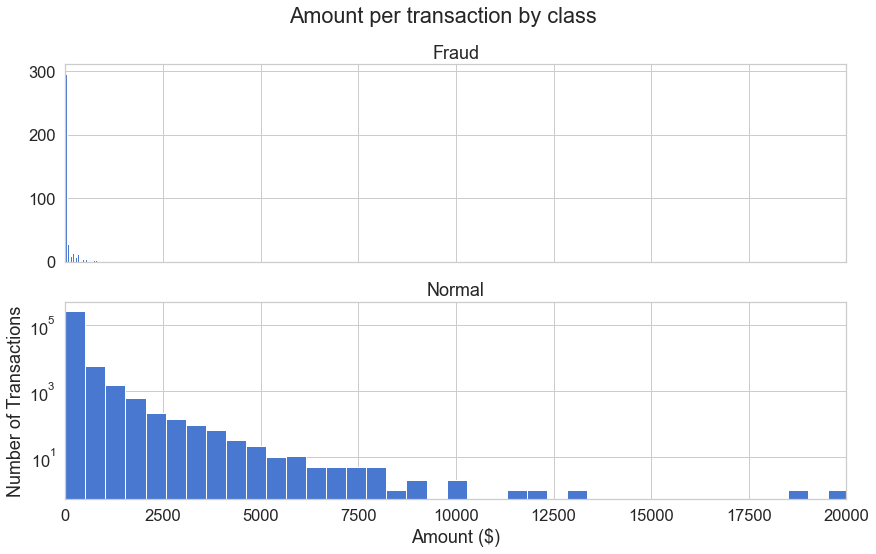

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

# Using Autoencoders

## Prepare the data

In [9]:
data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [10]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

## Build the Model

In [11]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [12]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [13]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
   1/7108 [..............................] - ETA: 0s - loss: 1.2064 - accuracy: 0.0312WARNING:tensorflow:From C:\Anaconda\envs\tf\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
7108/7108 [==============================] - 6s 840us/step - loss: 0.8053 - accuracy: 0.5921 - val_loss: 0.7853 - val_accuracy: 0.6518
Epoch 2/100
7108/7108 [==============================] - 6s 836us/step - loss: 0.7434 - accuracy: 0.6654 - val_loss: 0.7701 - val_accuracy: 0.6661
Epoch 3/100
7108/7108 [==============================] - 6s 850us/step - loss: 0.7319 - accuracy: 0.6792 - val_loss: 0.7630 - val_accuracy: 0.6794
Epoch 4/100
7108/7108 [==============================] - 6s 891us/step - loss: 0.7269 - accuracy: 0.6835 - val_loss: 0.7589 - val_accuracy: 0.6787
Epoch 5/100
7108/7108 [==========================

7108/7108 [==============================] - 7s 941us/step - loss: 0.6953 - accuracy: 0.7059 - val_loss: 0.7310 - val_accuracy: 0.7086
Epoch 53/100
7108/7108 [==============================] - 7s 945us/step - loss: 0.6949 - accuracy: 0.7059 - val_loss: 0.7292 - val_accuracy: 0.7100
Epoch 54/100
7108/7108 [==============================] - 7s 928us/step - loss: 0.6955 - accuracy: 0.7063 - val_loss: 0.7288 - val_accuracy: 0.7125
Epoch 55/100
7108/7108 [==============================] - 7s 925us/step - loss: 0.6950 - accuracy: 0.7057 - val_loss: 0.7314 - val_accuracy: 0.6990
Epoch 56/100
7108/7108 [==============================] - 7s 932us/step - loss: 0.6952 - accuracy: 0.7063 - val_loss: 0.7297 - val_accuracy: 0.7091
Epoch 57/100
7108/7108 [==============================] - 7s 928us/step - loss: 0.6952 - accuracy: 0.7053 - val_loss: 0.7294 - val_accuracy: 0.7099
Epoch 58/100
7108/7108 [==============================] - 7s 929us/step - loss: 0.6953 - accuracy: 0.7050 - val_loss: 0.7335 

In [14]:
autoencoder = load_model('model.h5')

## Evaluate

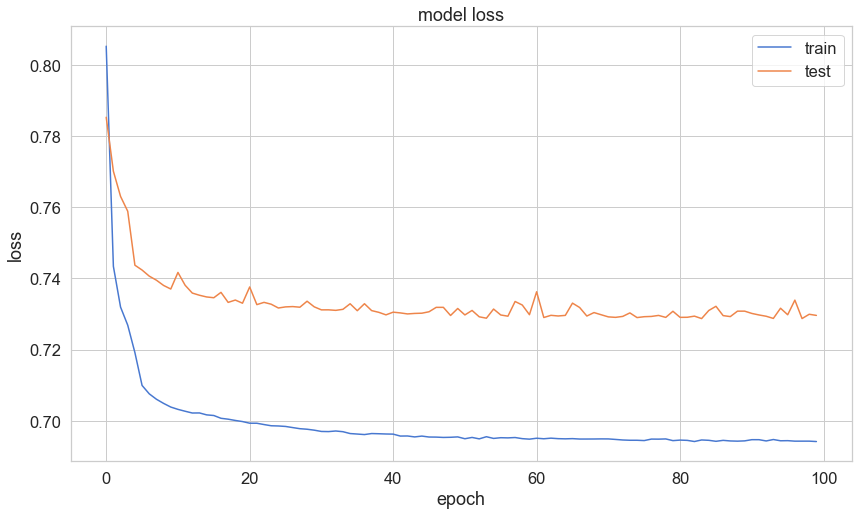

In [15]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [16]:
predictions = autoencoder.predict(X_test)

In [17]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [18]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.727816,0.001720
std,3.423761,0.041443
min,0.044565,0.000000
25%,0.238775,0.000000
50%,0.378350,0.000000
75%,0.614517,0.000000
max,258.844581,1.000000


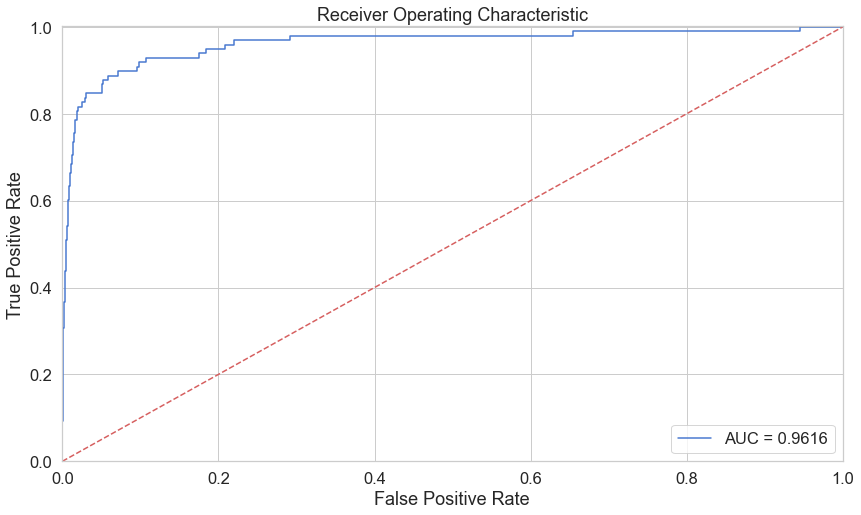

In [19]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

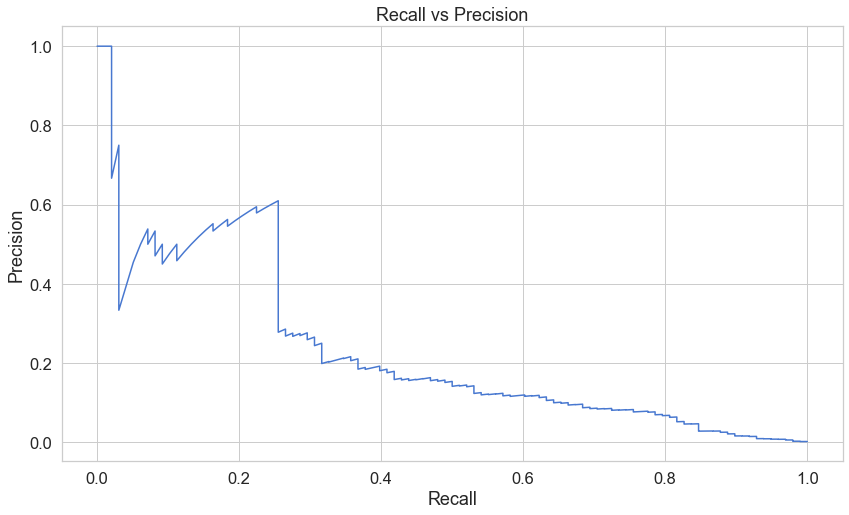

In [20]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

#### A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

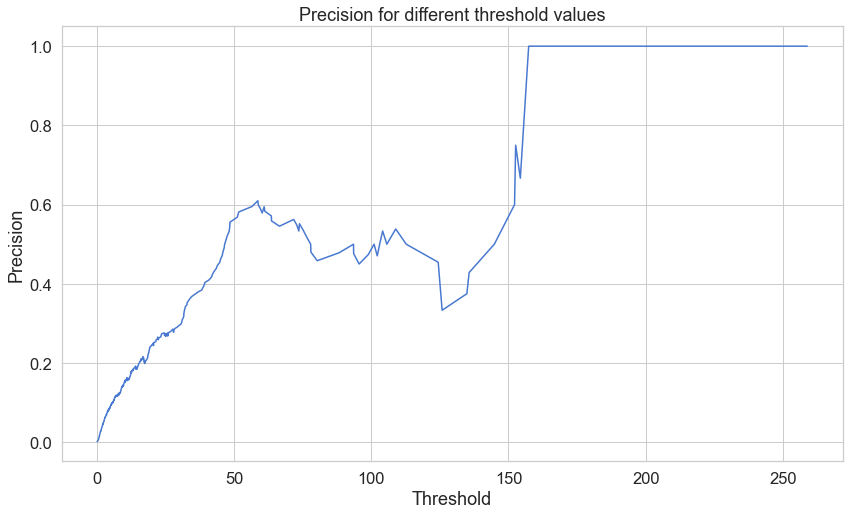

In [21]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

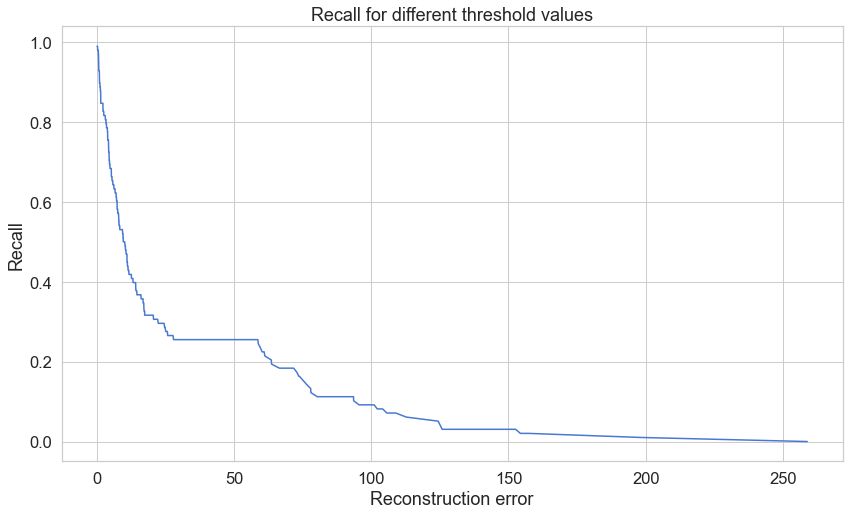

In [22]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [23]:
threshold = 2.9

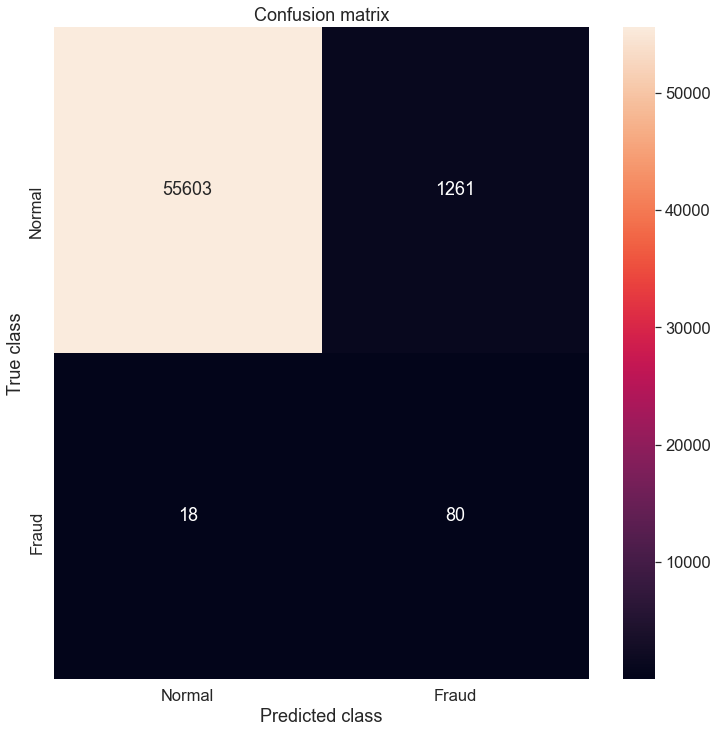

In [24]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Using Autoencoders with SMOTE

## Prepare the data

In [25]:
DATAFILE = 'creditcard.csv'
df = pd.read_csv(DATAFILE)

In [26]:
df = df.drop(['Time'], axis=1)
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

In [27]:
X = df.drop('Class', axis=1)
y = df['Class']

In [28]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=RANDOM_SEED)

## Build the Model

In [30]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [31]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [32]:
nb_epoch = 50
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/50
14216/14216 [==============================] - 13s 938us/step - loss: 12.0481 - accuracy: 0.4832 - val_loss: 11.8422 - val_accuracy: 0.6102
Epoch 2/50
14216/14216 [==============================] - 13s 883us/step - loss: 11.7859 - accuracy: 0.6530 - val_loss: 11.8070 - val_accuracy: 0.6823
Epoch 3/50
14216/14216 [==============================] - 13s 942us/step - loss: 11.7636 - accuracy: 0.6886 - val_loss: 11.7848 - val_accuracy: 0.7010
Epoch 4/50
14216/14216 [==============================] - 13s 916us/step - loss: 11.7495 - accuracy: 0.7009 - val_loss: 11.7791 - val_accuracy: 0.7047
Epoch 5/50
14216/14216 [==============================] - 13s 916us/step - loss: 11.7430 - accuracy: 0.7059 - val_loss: 11.7745 - val_accuracy: 0.7128
Epoch 6/50
14216/14216 [==============================] - 13s 923us/step - loss: 11.7398 - accuracy: 0.7109 - val_loss: 11.7696 - val_accuracy: 0.7097
Epoch 7/50
14216/14216 [==============================] - 13s 921us/step - loss: 11.7377 - acc

In [33]:
autoencoder = load_model('model.h5')

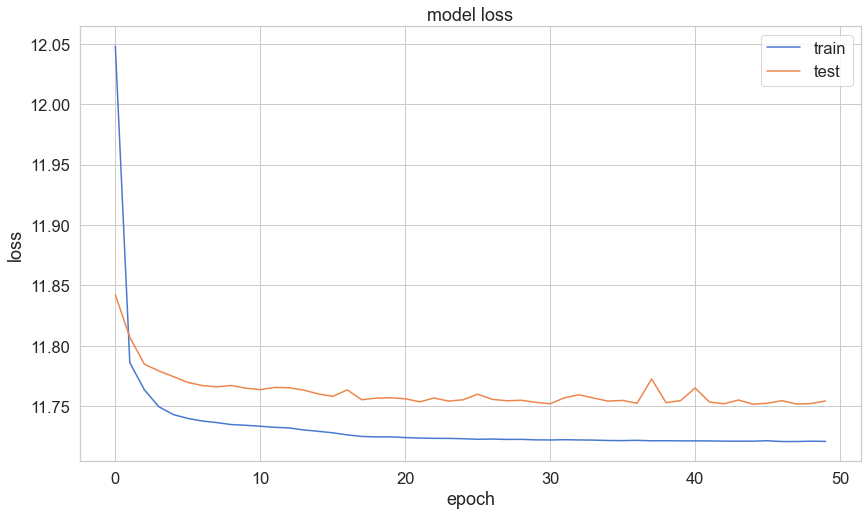

In [34]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [35]:
predictions = autoencoder.predict(X_test)

In [36]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [37]:
error_df.describe()

,reconstruction_error,true_class
count,113726.000000,113726.000000
mean,11.750605,0.500994
std,25.410386,0.500001
min,0.058878,0.000000
25%,0.390895,0.000000
50%,0.953422,1.000000
75%,8.051583,1.000000
max,355.061277,1.000000


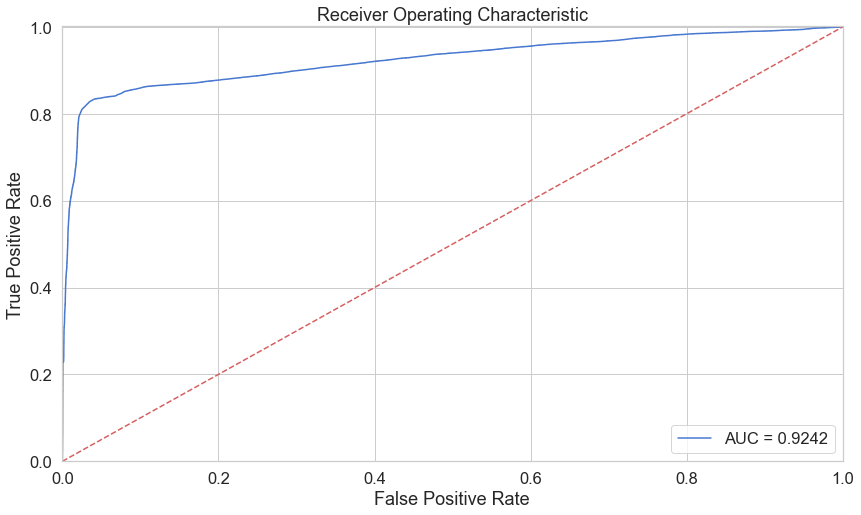

In [38]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

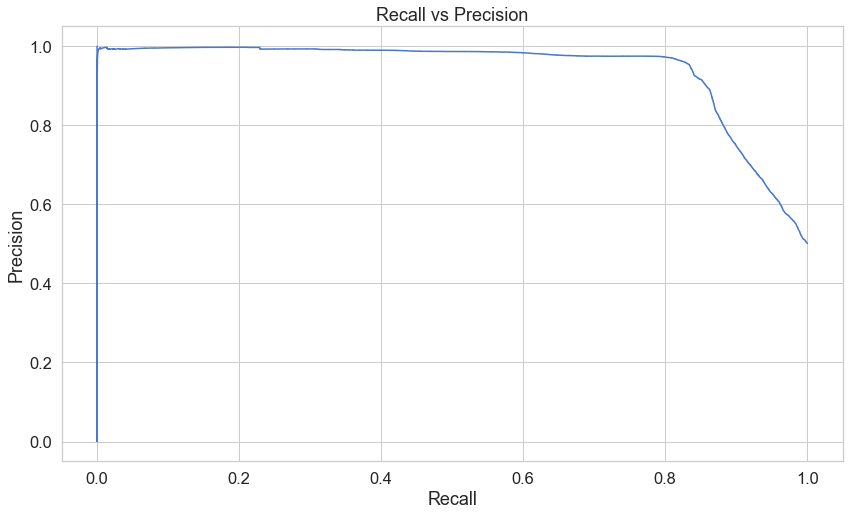

In [39]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

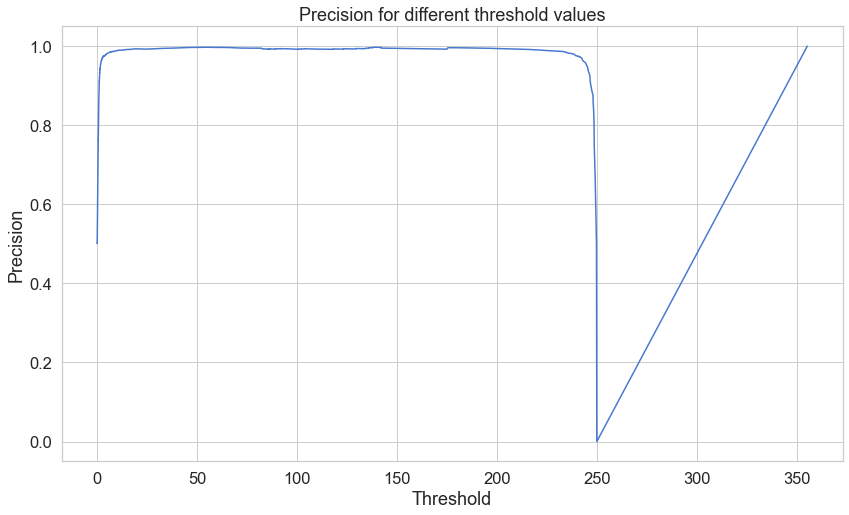

In [40]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

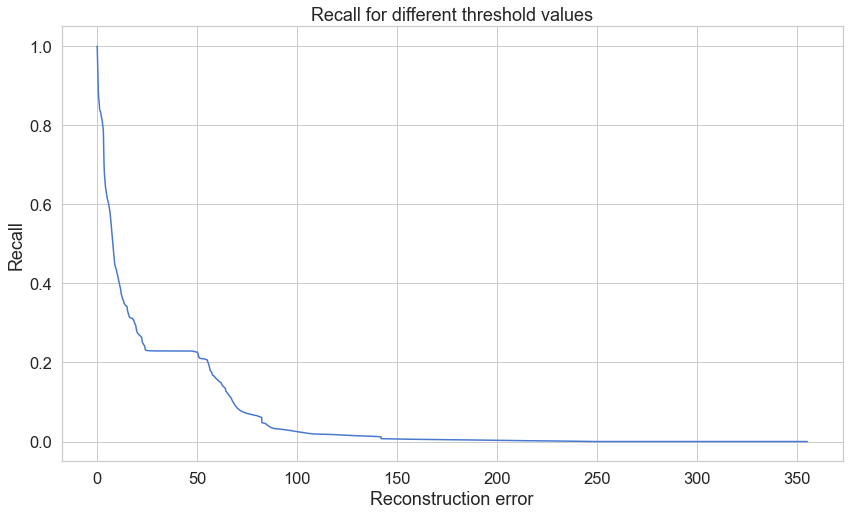

In [41]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [42]:
threshold = 2.9

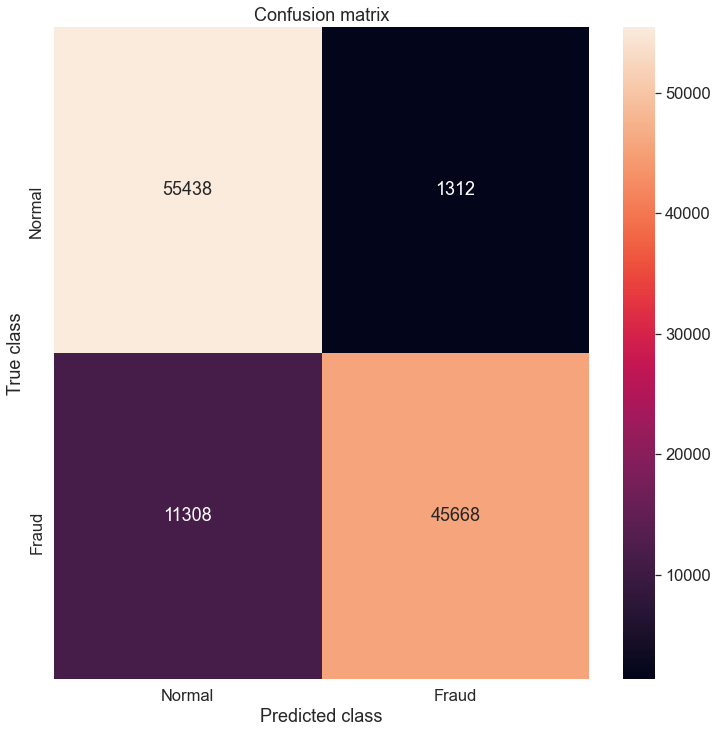

In [43]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## END of File 2